In [1]:
## data
import pandas as pd
import numpy as np
import datetime as dt
from dateutil.relativedelta import relativedelta
from unicodedata import normalize

## vis
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# contagem de aging
from collections import Counter

from IPython.display import display, HTML

## modelo
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# check xgboost version
from xgboost import XGBClassifier

## alertas
import warnings
warnings.filterwarnings("ignore")

***
## Coleta de dados

In [2]:
FILE = "/kaggle/input/datasetsnew/batdtfim500kage.csv"
dados = pd.read_csv(FILE, sep = ';', encoding = 'ISO-8859-1', engine ='python')

dados = dados.rename(columns={'a.msisdn': 'msisdn'})\
             .rename(columns={'a.imsi': 'imsi'})\
             .rename(columns={'a.tac': 'tac'})\
             .rename(columns={'a.dt_inicio': 'dt_inicio'})\
             .rename(columns={'a.dt_fim': 'dt_fim'})\
             .rename(columns={'a.aging_aparelho': 'aging_aparelho'})\
             .rename(columns={'a.cat_aparelho': 'cat_aparelho'})\
             .rename(columns={'a.trocou_aparelho': 'trocou_aparelho'})\
             .rename(columns={'a.fabricante': 'fabricante'})\
             .rename(columns={'a.modelo': 'modelo'})\
             .rename(columns={'a.imei': 'imei'})\
             .rename(columns={'a.ranking': 'ranking'})\
             .rename(columns={'a.cpfidentifier': 'cpfidentifier'})\
             .rename(columns={'a.subscriberkey': 'subscriberkey'})\
             .rename(columns={'a.customerkey': 'customerkey'})\
             .rename(columns={'a.customersubtypedesc': 'customersubtypedesc'})\
             .rename(columns={'a.subscriberstatuskey': 'subscriberstatuskey'})\
             .rename(columns={'a.offertechnology': 'offertechnology'})\
             .rename(columns={'a.citydesc': 'citydesc'})\
             .rename(columns={'a.statedesc': 'statedesc'})\
             .rename(columns={'a.subscribermainofferdesc': 'subscribermainofferdesc'})\
             .rename(columns={'a.assignedchargeamount': 'assignedchargeamount'})\
             .rename(columns={'a.fl_3g': 'fl_3g'})\
             .rename(columns={'a.fl_4g': 'fl_4g'})\
             .rename(columns={'a.fl_5g': 'fl_5g'})\
             .rename(columns={'a.dt_ano_stts': 'dt_ano_stts'})\
             .rename(columns={'a.idade': 'idade'})\


dados

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,5532998068556,724235404829984,35415808,2021-02-17,2022-04-09,13,1,1,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),...,PostPaid,NaN,MINAS GERAIS,LINHA ADICIONAL VIVO FAMÃLIA 150GB,0.00,0.0,1.0,0.0,2016.0,31
1,5521988674638,724112005547717,35690411,2021-05-29,NaN,16,1,0,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,...,Controle,NaN,RIO DE JANEIRO,VIVO CTRL DIGITAL_11GB ILIM_,67.14,0.0,1.0,0.0,2020.0,83
2,5555999595054,724065007509989,35175119,2021-03-31,NaN,18,1,0,SAMSUNG,"GALAXY S21 PLUS 5G (SM-G996B,DS)",...,PostPaid,NaN,RIO GRANDE DO SUL,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,0.0,1.0,2020.0,56
3,5527997623734,724113001405241,35991710,2021-05-29,NaN,16,1,0,Multilaser Industrial S.A.,MULTILASER F PRO,...,Controle,NaN,ESPIRITO SANTO,VIVO CONTROLE DIG-7GB_,52.88,0.0,1.0,0.0,2019.0,65
4,5567996046665,724066795495313,35613011,2021-07-23,NaN,14,1,0,SAMSUNG,"GALAXY A01 (SM-A015M,DS)",...,Controle,NaN,MATO GROSSO DO SUL,VIVO CONTROLE 4GB IV,37.49,0.0,1.0,0.0,2020.0,48
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,5541992819276,724064006643479,35892323,2021-05-06,NaN,17,1,0,Samsung Korea,GALAXY A52 5G,...,PostPaid,NaN,PARANA,LINHA ADICIONAL VIVO FAMILIA 150GB,0.00,0.0,0.0,1.0,2020.0,63
499996,5511941319852,724102190782505,35092033,2021-03-25,NaN,18,1,0,"Motorola Mobility LLC, a Lenovo Company",GUAM+20,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 7GB_,53.35,0.0,1.0,0.0,2020.0,50
499997,5518996551019,724101993846396,35690411,2021-09-03,NaN,13,1,0,"Motorola Mobility LLC, a Lenovo Company",ODESSA20,...,Controle,NaN,SAO PAULO,VIVO CONTROLE 4GB,37.61,0.0,1.0,0.0,2020.0,58
499998,5561982989551,724066490746154,35614110,2021-10-15,NaN,12,1,0,SAMSUNG,"GALAXY A30 (SM-A305GT,DS)",...,PostPaid,NaN,DISTRITO FEDERAL,TITULAR VIVO FAMILIA 60GB - MENSAL,234.99,0.0,1.0,0.0,2019.0,51


### Limpeza dos dados

In [3]:
def just_check_nan(df):
    # Check NaN Pandas and Numpy
    missing_val_count_by_column = (df.isna().sum())

    columns_with_nan = missing_val_count_by_column[missing_val_count_by_column > 0]
    print('Dados com NaN:')
    print(columns_with_nan)
    print('')
    print('columns_with_nan.shape', columns_with_nan.shape)
    print('')

In [4]:
just_check_nan(dados)

Dados com NaN:
dt_fim                     401174
citydesc                   500000
statedesc                      71
subscribermainofferdesc     36797
assignedchargeamount        36719
fl_3g                         107
fl_4g                         107
fl_5g                         107
dt_ano_stts                   107
dtype: int64

columns_with_nan.shape (9,)



In [5]:
dados_droped = dados.dropna(subset=['imsi',
                                    'statedesc', 
                                    'subscribermainofferdesc', 
                                    'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts'])\
                    .reset_index(drop=True)
# dados_droped

In [6]:
just_check_nan(dados_droped)

Dados com NaN:
dt_fim      367716
citydesc    462975
dtype: int64

columns_with_nan.shape (2,)



### Equilibrando classes

In [7]:
dados_droped_0 = dados_droped[dados_droped['trocou_aparelho'] == 0].sample(frac=0.53, random_state=3)
dados_droped_1 = dados_droped[dados_droped['trocou_aparelho'] == 1]

In [8]:
dados_droped = pd.concat([dados_droped_0, dados_droped_1]).reset_index(drop=True).sort_values(by='msisdn', ascending=False)
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
191243,5599999778280,724119113878348,35768964,2021-05-17,2022-05-19,12,1,1,Samsung Korea,GALAXY NOTE20 ULTRA 5G,...,PostPaid,NaN,MARANHAO,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,109.99,0.0,0.0,1.0,2020.0,63
265747,5599999778280,724119113878348,35768964,2021-05-17,2022-05-19,12,1,1,Samsung Korea,GALAXY NOTE20 ULTRA 5G,...,PostPaid,NaN,MARANHAO,TITULAR VIVO SELFIE - AMAZON PRIME - 20GB,109.99,0.0,0.0,1.0,2020.0,63
259546,5599999770208,724119112384725,35767712,2021-05-04,2022-05-17,12,1,1,APPLE,IPHONE 12 PRO MAX (A2411),...,PostPaid,NaN,MARANHAO,LINHA ADICIONAL VIVO V,0.00,0.0,0.0,1.0,2020.0,29
72070,5599999530131,724119114015020,35260709,2021-07-09,NaN,15,1,0,SAMSUNG,GALAXY J7 PRIME (SM-G610M DS),...,PostPaid,NaN,MARANHAO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017.0,30
42435,5599999523030,724119805984364,35973519,2021-07-14,NaN,15,1,0,APPLE,IPHONE 12 PRO MAX (A2342),...,PostPaid,NaN,MARANHAO,TITULAR VIVO V,1299.99,0.0,0.0,1.0,2021.0,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212775,5511910003326,724102090904887,35187408,2021-02-03,2022-05-02,14,1,1,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",...,PostPaid,NaN,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016.0,48
110399,5511910002444,724102007070038,35324910,2021-07-13,NaN,15,1,0,APPLE,IPHONE 11 PRO (A2160),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,1.0,0.0,2019.0,51
39865,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017.0,36
224554,5511910001363,724102007216056,35470311,2021-02-19,2022-04-17,13,1,1,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",...,PostPaid,NaN,SAO PAULO,TITULAR VIVO FAMILIA 60GB,235.13,0.0,1.0,0.0,2019.0,60


In [9]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({1: 103403, 0: 190573})

In [10]:
dados_droped = dados_droped.tail(dados_droped.shape[0] -70000).reset_index(drop=True)
dados_droped['dt_ano_stts'] = dados_droped['dt_ano_stts'].astype(np.int64).reset_index(drop=True)
# dados_droped2 = dados_droped[dados_droped['trocou_aparelho'] == 1].reset_index()
dados_droped

,msisdn,imsi,tac,dt_inicio,dt_fim,aging_aparelho,cat_aparelho,trocou_aparelho,fabricante,modelo,...,offertechnology,citydesc,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,5561999581924,724066795380751,86837904,2021-08-23,NaN,13,1,0,XIAOMI,REDMI NOTE 8 (M1908C3JG),...,Controle,NaN,DISTRITO FEDERAL,VIVO CONTROLE 5GB II,45.99,0.0,1.0,0.0,2020,54
1,5561999581532,724066490804699,35479015,2021-08-31,NaN,13,1,0,APPLE,IPHONE 11 (A2221),...,Controle,NaN,DISTRITO FEDERAL,VIVO CONTROLE 11GB - ANUAL_,65.72,0.0,1.0,0.0,2021,53
2,5561999581034,724066612704467,86138304,2021-06-23,NaN,15,1,0,XIAOMI,MI 9T (M1903F10G),...,Controle,NaN,DISTRITO FEDERAL,VIVO CONTROLE 6GB III,45.99,0.0,1.0,0.0,2018,61
3,5561999581013,724066793802271,35468406,2020-08-28,2022-02-15,17,1,1,SAMSUNG,GALAXY CORE II DUAL SIM (SM-G355M),...,PostPaid,NaN,DISTRITO FEDERAL,Linha Adicional Vivo PÃ³s FamÃ­lia 180GB,0.00,1.0,0.0,0.0,2014,48
4,5561999580934,724066635075960,35589711,2021-05-28,NaN,16,1,0,LG,LM-K200BMW,...,Controle,NaN,DISTRITO FEDERAL,VIVO CONTROLE 5GB IV,36.99,0.0,1.0,0.0,2020,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
223971,5511910003326,724102090904887,35187408,2021-02-03,2022-05-02,14,1,1,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",...,PostPaid,NaN,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016,48
223972,5511910002444,724102007070038,35324910,2021-07-13,NaN,15,1,0,APPLE,IPHONE 11 PRO (A2160),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,1.0,0.0,2019,51
223973,5511910001745,724102802140721,35188909,2021-09-21,NaN,12,1,0,MOTOROLA,MOTOROLA MOTO G5S (XT1792),...,PostPaid,NaN,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36
223974,5511910001363,724102007216056,35470311,2021-02-19,2022-04-17,13,1,1,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",...,PostPaid,NaN,SAO PAULO,TITULAR VIVO FAMILIA 60GB,235.13,0.0,1.0,0.0,2019,60


In [11]:
dados_droped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223976 entries, 0 to 223975
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   msisdn                   223976 non-null  int64  
 1   imsi                     223976 non-null  int64  
 2   tac                      223976 non-null  int64  
 3   dt_inicio                223976 non-null  object 
 4   dt_fim                   70923 non-null   object 
 5   aging_aparelho           223976 non-null  int64  
 6   cat_aparelho             223976 non-null  int64  
 7   trocou_aparelho          223976 non-null  int64  
 8   fabricante               223976 non-null  object 
 9   modelo                   223976 non-null  object 
 10  imei                     223976 non-null  object 
 11  ranking                  223976 non-null  int64  
 12  cpfidentifier            223976 non-null  int64  
 13  subscriberkey            223976 non-null  int64  
 14  cust

***
### Analise individual

In [12]:
dados_droped['cat_aparelho'].unique()

array([1])

In [13]:
dados_droped['trocou_aparelho'].unique()

array([0, 1])

In [14]:
dados_droped['aging_aparelho'].unique()

array([13, 15, 17, 16, 18, 14, 12])

In [15]:
dados_droped['customersubtypedesc'].unique()

array(['Pessoa FÃ\xadsica'], dtype=object)

In [16]:
dados_droped['subscriberstatuskey'].unique()

array(['A'], dtype=object)

In [17]:
dados_droped['ranking'].unique()

array([1, 2])

In [18]:
dados_droped['assignedchargeamount'].unique()

array([ 45.99,  65.72,   0.  , ..., 211.61, 180.5 , 113.15])

In [19]:
dados_droped['fl_3g'].equals(dados_droped['fl_4g'])

False

In [20]:
dados_droped['fl_3g'].equals(dados_droped['fl_5g'])

False

In [21]:
dados_droped['fl_4g'].equals(dados_droped['fl_5g'])

False

In [22]:
dados_droped['trocou_aparelho'].unique()

array([0, 1])

In [23]:
dados_droped['idade'].unique()

array([ 54,  53,  61,  48,  22,  37,  43,  36,  70,  50,  49,  59,  63,
        42,  40,  46,  45,  35,  56,  44,  34,  80,  41,  74,  60,  31,
        64,  27,  57,  58,  52,  19,  39,  18,  51,  67,  23,  68,  33,
        25,  93,  79,  55,  47,  20,  32,  29,  38,  30,  24,  71,  84,
        21,  65,  72,  73,  62,  83,  76,  26,  28,  66,  78,  75,  69,
        89,  87,  94,  85,  77,  82, 122,  92,   4,  88,  95,  81,  91,
        86,  90,  98,  16,   3,   1,  13,   2,   9,  96,  11, 251,  17,
       148, 102, 111,   0, 269,  97, 150, 146, 101])

***
### Correlação entre meses e trocou_aparelho

fazer uma analise com correlação e / ou gráficos dos meses maio, agosto, novembro e dezembro com trocou_aparelho

In [24]:
# dados_droped[dados_droped['trocou_aparelho'] == ]

In [25]:
# dados_droped[pd.to_datetime(dados_droped['dt_inicio']) == '2022-09'] fazendo correlação com os meses

***
## Exploração dos dados

### seleção de features

In [26]:
# define features
X_ta = dados_droped[['fabricante', 'modelo', 'ranking', 'aging_aparelho', 
                     'offertechnology', 
                     'statedesc', 'subscribermainofferdesc', 'assignedchargeamount', 
                     'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']]
X_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,XIAOMI,REDMI NOTE 8 (M1908C3JG),1,13,Controle,DISTRITO FEDERAL,VIVO CONTROLE 5GB II,45.99,0.0,1.0,0.0,2020,54
1,APPLE,IPHONE 11 (A2221),1,13,Controle,DISTRITO FEDERAL,VIVO CONTROLE 11GB - ANUAL_,65.72,0.0,1.0,0.0,2021,53
2,XIAOMI,MI 9T (M1903F10G),1,15,Controle,DISTRITO FEDERAL,VIVO CONTROLE 6GB III,45.99,0.0,1.0,0.0,2018,61
3,SAMSUNG,GALAXY CORE II DUAL SIM (SM-G355M),1,17,PostPaid,DISTRITO FEDERAL,Linha Adicional Vivo PÃ³s FamÃ­lia 180GB,0.00,1.0,0.0,0.0,2014,48
4,LG,LM-K200BMW,1,16,Controle,DISTRITO FEDERAL,VIVO CONTROLE 5GB IV,36.99,0.0,1.0,0.0,2020,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...
223971,"Motorola Mobility LLC, a Lenovo Company","MOTO G (4TH GEN), AF12788145",1,14,PostPaid,SAO PAULO,Titular INTERNET_MOVEL_100GB,112.30,0.0,1.0,0.0,2016,48
223972,APPLE,IPHONE 11 PRO (A2160),1,15,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 100GB,0.00,0.0,1.0,0.0,2019,51
223973,MOTOROLA,MOTOROLA MOTO G5S (XT1792),1,12,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,1.0,0.0,2017,36
223974,SAMSUNG,"GALAXY A71 (SM-A715F,DSM)",1,13,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 60GB,235.13,0.0,1.0,0.0,2019,60


In [27]:
X_ta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223976 entries, 0 to 223975
Data columns (total 13 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   fabricante               223976 non-null  object 
 1   modelo                   223976 non-null  object 
 2   ranking                  223976 non-null  int64  
 3   aging_aparelho           223976 non-null  int64  
 4   offertechnology          223976 non-null  object 
 5   statedesc                223976 non-null  object 
 6   subscribermainofferdesc  223976 non-null  object 
 7   assignedchargeamount     223976 non-null  float64
 8   fl_3g                    223976 non-null  float64
 9   fl_4g                    223976 non-null  float64
 10  fl_5g                    223976 non-null  float64
 11  dt_ano_stts              223976 non-null  int64  
 12  idade                    223976 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 22.2+ MB


#### Variaveis Categoricas

In [28]:
# Get list of categorical variables
s_ta = (X_ta.dtypes == 'object')
object_cols_ta = list(s_ta[s_ta].index)
print("Categorical variables: ", len(object_cols_ta))
print(object_cols_ta)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [29]:
# Criando uma lista de variaveis numéricas
numerical_cols_ta = [cname for cname in X_ta.columns if X_ta[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols_ta))
print(numerical_cols_ta)

Numerical variables:  8
['ranking', 'aging_aparelho', 'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']


***
## Mostrando a correlação entre os dados numéricos

In [30]:
corr_trocou_aparelho = dados_droped[['fabricante', 'modelo',
                                     'ranking', 'aging_aparelho',
                                     'offertechnology', 
                                     'statedesc', 'subscribermainofferdesc',
                                     'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                     'dt_ano_stts', 'idade', 'trocou_aparelho']]

<AxesSubplot:>

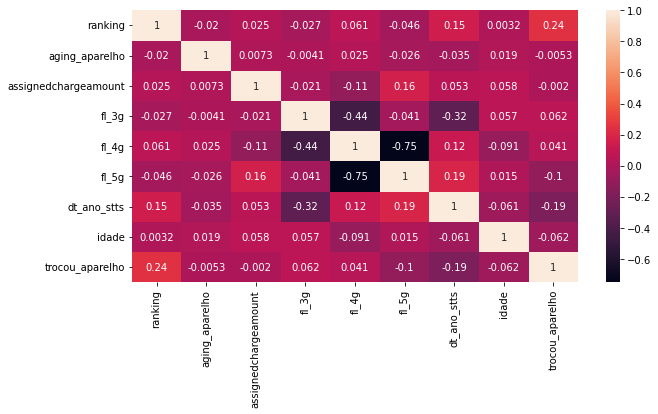

In [31]:
corr = corr_trocou_aparelho.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr, xticklabels = corr.columns, yticklabels = corr.columns, annot = True)

***
***
***
## Definição do Target trocou_aparelho

In [32]:
def plot_feature_freq(df, feature, qt_cat):
    labels, counts = np.unique(df[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    order = np.argsort(counts)[::-1]
    labels, counts = labels[order], counts[order]

    g = sns.barplot(labels[:qt_cat], counts[:qt_cat])
    g.set_xticklabels(labels[:qt_cat], rotation=90)
    
    return g

In [33]:
# define target
y_trocou_aparelho = dados_droped['trocou_aparelho']

c_trocou_aparelho = Counter(y_trocou_aparelho)
c_trocou_aparelho

Counter({0: 146564, 1: 77412})

In [34]:
# calculo da proporção da base
estimate = c_trocou_aparelho[0] / c_trocou_aparelho[1]
estimate

1.8932981966620162

<AxesSubplot:>

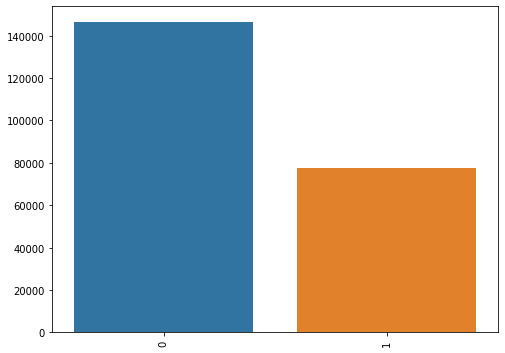

In [35]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(dados_droped, 'trocou_aparelho', len(dados_droped['trocou_aparelho'].unique()))

***
## Modelagem trocou_aparelho

In [36]:
# Dividindo as features em dados de treino e teste
X_train_ta, X_val_ta, y_train_ta, y_val_ta = train_test_split(X_ta, 
                                                              y_trocou_aparelho, 
                                                              test_size=0.5, 
                                                              random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer_ta = Pipeline([
                                     ('scaler', StandardScaler())
                                    ])

# Pré-processamento para Dados Categóricos
categorical_transformer_ta = Pipeline([
                                       ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                      ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor_ta = ColumnTransformer(transformers=[
                                                  ('num', numerical_transformer_ta, numerical_cols_ta),
                                                  ('cat', categorical_transformer_ta, object_cols_ta)
                                                 ], n_jobs=-1)

pipeline_ta = Pipeline(steps=[
                              ('preprocessor', preprocessor_ta),
                              ('smote', SMOTE(random_state=42, n_jobs=-1)),
                              ('model', RandomForestClassifier(random_state=2048))
#                               ('model', GradientBoostingClassifier(random_state=2048))
#                               ('model', XGBClassifier(scale_pos_weight=estimate, random_state=2048))
                             ])

# Preprocessing of training data, fit model 
pipeline_ta.fit(X_train_ta, y_train_ta)

# Predictions
# preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds_ta = pipeline_ta.predict(X_val_ta)

In [37]:
c_train_ta = Counter(y_train_ta)
c_train_ta


Counter({0: 73362, 1: 38626})

In [38]:
c_val_ta = Counter(y_val_ta)
c_val_ta


Counter({1: 38786, 0: 73202})

In [39]:
c_preds_ta = Counter(preds_ta)
c_preds_ta

Counter({0: 79338, 1: 32650})

***
## Métricas

In [40]:
print(classification_report(y_val_ta, preds_ta))

              precision    recall  f1-score   support

           0       0.75      0.81      0.78     73202
           1       0.58      0.49      0.53     38786

    accuracy                           0.70    111988
   macro avg       0.67      0.65      0.66    111988
weighted avg       0.69      0.70      0.70    111988



In [41]:
cm_df_ta = pd.DataFrame(confusion_matrix(y_val_ta, preds_ta),
                     index = sorted(Counter(y_val_ta)),
                     columns = sorted(Counter(preds_ta)))
cm_df_ta

,0,1
0,59638,13564
1,19700,19086


Confusion matrix, without normalization
[[59638 13564]
 [19700 19086]]
Normalized confusion matrix
[[0.81470452 0.18529548]
 [0.50791523 0.49208477]]


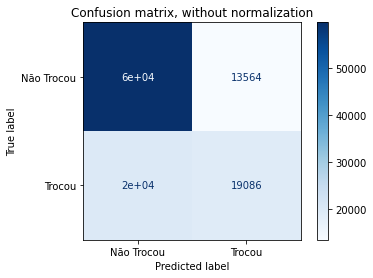

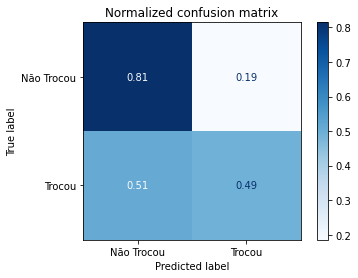

<Figure size 1296x1296 with 0 Axes>

In [42]:
# Plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline_ta,
        X_val_ta,
        y_val_ta,
        display_labels=['Não Trocou', 'Trocou'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

## Captação dos clientes que foram previstos como Propensos a Fazer uma Compra

In [43]:
X_val_ta['trocou_aparelho'] = y_val_ta
# X_val_ta

<AxesSubplot:>

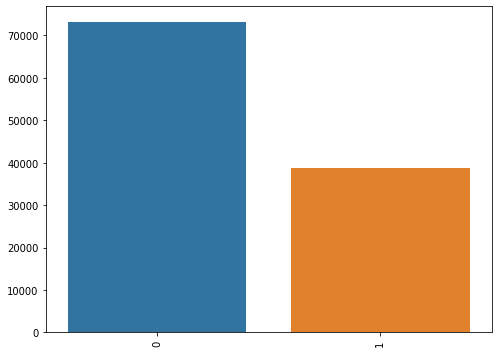

In [44]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho', len(X_val_ta['trocou_aparelho'].unique()))

In [45]:
X_val_ta['trocou_aparelho_previsto'] = preds_ta
# X_val_ta

<AxesSubplot:>

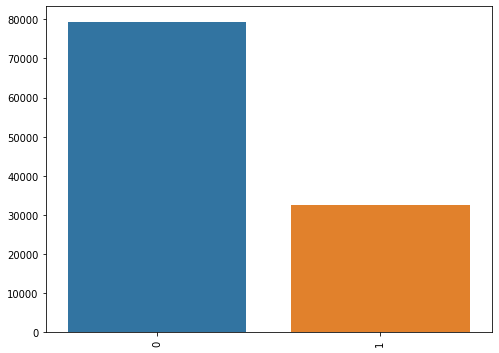

In [46]:
plt.figure(figsize=(8, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val_ta, 'trocou_aparelho_previsto', len(X_val_ta['trocou_aparelho_previsto'].unique()))

In [47]:
X_val_ta['cpfidentifier'] = dados_droped['cpfidentifier']
# X_val_ta

In [48]:
X_val_ta['dt_inicio'] = dados_droped['dt_inicio']
# X_val_ta

In [49]:
X_val_ta['dt_fim'] = dados_droped['dt_fim']
X_val_ta

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim
100195,SAMSUNG,"GALAXY A30 (SM-A305GT,DS)",1,16,Controle,ESPIRITO SANTO,VIVO CONTROLE 5GB II PLN,36.99,0.0,1.0,0.0,2019,34,1,0,5928365764,2021-01-03,2022-06-01
86609,SAMSUNG,"GALAXY S10 PLUS (SM-G975F,DS)",1,15,Controle,MINAS GERAIS,VIVO CONTROLE 9GB I PLN,60.99,0.0,1.0,0.0,2018,26,1,0,11554167671,2021-01-21,2022-04-25
80961,SAMSUNG,GALAXY ON7 REFRESH (SM-G611MT DS),1,13,Controle,MINAS GERAIS,VIVOCONTROLEDIGITAL-9GB ILIM_,95.99,0.0,1.0,0.0,2018,66,1,0,31539750604,2021-04-24,2022-05-24
103370,Samsung Korea,GALAXY S20 FE LTE,1,13,Controle,ESPIRITO SANTO,VIVO CONTROLE 9GB I,56.49,0.0,1.0,0.0,2021,48,0,0,6848431702,2021-09-18,NaN
160547,APPLE,IPHONE 12 PRO (A2341),1,14,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 200GB,0.00,0.0,0.0,1.0,2020,61,0,0,2105074898,2021-08-05,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94064,XIAOMI,REDMI NOTE 9S (M2003J6A1G),1,16,Controle,ESPIRITO SANTO,VIVO CONTROLE 5GB II,46.82,0.0,1.0,0.0,2020,43,0,0,7811873702,2021-05-29,NaN
140915,XIAOMI,REDMI NOTE 9S (M2003J6A1G),1,16,Controle,SAO PAULO,VIVO CONTROLE 9GB I,62.01,0.0,1.0,0.0,2020,31,0,0,39273452884,2021-05-23,NaN
155323,"Motorola Mobility LLC, a Lenovo Company",SOFIA,1,13,Controle,SAO PAULO,VIVO CONTROLE 6GB III,45.99,0.0,1.0,0.0,2019,42,0,1,28917582850,2021-09-08,NaN
14216,"Motorola Mobility LLC, a Lenovo Company",MOTO G(9) PLAY,1,18,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 8GB II,55.99,0.0,1.0,0.0,2021,36,0,0,1096999048,2021-04-10,NaN


***
***
***
## Separando as bases para outro modelo

In [50]:
base_to_pred_month = X_val_ta[X_val_ta['trocou_aparelho_previsto'] == 1].reset_index(drop=True)
base_to_pred_month

,fabricante,modelo,ranking,aging_aparelho,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,trocou_aparelho,trocou_aparelho_previsto,cpfidentifier,dt_inicio,dt_fim
0,"Motorola Mobility LLC, a Lenovo Company",MOTOROLA ONE,1,17,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_ANUAL_,52.88,0.0,1.0,0.0,2018,26,1,1,3932240073,2020-12-30,2022-06-05
1,APPLE,IPHONE 11 (A2221),1,14,Controle,RIO GRANDE DO SUL,VIVO CTRL DIGITAL-11GB ILIM_,67.03,0.0,1.0,0.0,2020,23,0,1,2855558042,2021-08-07,NaN
2,SAMSUNG,"GALAXY A51 (SM-A515F,DSN)",1,13,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO V,0.00,0.0,1.0,0.0,2019,40,1,1,22601235896,2021-02-25,2022-03-31
3,Samsung Korea,2018 GALAXY J4,1,14,Controle,SAO PAULO,VIVO CONTROLE 4GB,42.61,0.0,1.0,0.0,2018,58,0,1,16828923871,2021-08-08,NaN
4,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),1,15,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,0.00,0.0,1.0,0.0,2017,61,0,1,7488604873,2021-06-24,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32645,"Motorola Mobility LLC, a Lenovo Company",SOFIA,1,17,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 60GB PLN,124.00,0.0,1.0,0.0,2019,51,1,1,14529842800,2020-12-10,2022-05-14
32646,Xiaomi Communications Co Ltd,REDMI 6A,1,18,Controle,MINAS GERAIS,VIVO CONTROLE 7GB_,52.31,0.0,1.0,0.0,2019,42,1,1,10887450679,2020-10-21,2022-05-05
32647,APPLE,IPHONE 11 PRO MAX (A2218),1,16,PostPaid,DISTRITO FEDERAL,TITULAR VIVO SELFIE PREMIERE 40GB,179.99,0.0,1.0,0.0,2019,38,1,1,80686850220,2020-11-06,2022-03-17
32648,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),1,16,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,32.49,0.0,1.0,0.0,2017,53,1,1,12896910883,2020-11-24,2022-04-07


***
***
***
## Definição do Target aging_aparelho

In [51]:
# define target
y = base_to_pred_month['aging_aparelho']

In [52]:
# contagem de aging
from collections import Counter

c = Counter(y)
c

Counter({17: 4296, 14: 4758, 13: 5124, 15: 4582, 16: 4257, 12: 5725, 18: 3908})

<AxesSubplot:>

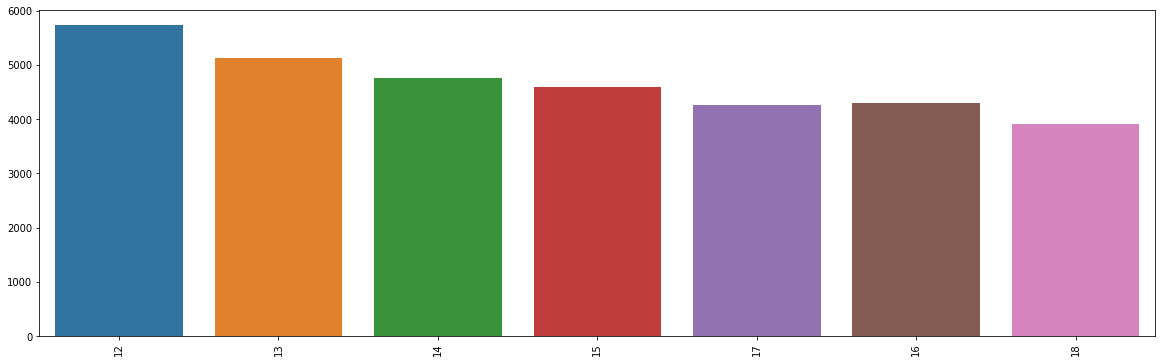

In [53]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho', len(base_to_pred_month['aging_aparelho'].unique()))

### Definicão das features

In [54]:
# define features
X = base_to_pred_month[['fabricante', 'modelo',
                        'ranking',
                        'offertechnology', 
                        'statedesc', 'subscribermainofferdesc',
                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                        'dt_ano_stts', 'idade']]
X

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade
0,"Motorola Mobility LLC, a Lenovo Company",MOTOROLA ONE,1,Controle,RIO GRANDE DO SUL,VIVO CONTROLE 7GB_ANUAL_,52.88,0.0,1.0,0.0,2018,26
1,APPLE,IPHONE 11 (A2221),1,Controle,RIO GRANDE DO SUL,VIVO CTRL DIGITAL-11GB ILIM_,67.03,0.0,1.0,0.0,2020,23
2,SAMSUNG,"GALAXY A51 (SM-A515F,DSN)",1,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO V,0.00,0.0,1.0,0.0,2019,40
3,Samsung Korea,2018 GALAXY J4,1,Controle,SAO PAULO,VIVO CONTROLE 4GB,42.61,0.0,1.0,0.0,2018,58
4,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),1,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 10GB PLN+110GB BONUS,0.00,0.0,1.0,0.0,2017,61
...,...,...,...,...,...,...,...,...,...,...,...,...
32645,"Motorola Mobility LLC, a Lenovo Company",SOFIA,1,PostPaid,SAO PAULO,TITULAR VIVO FAMILIA 60GB PLN,124.00,0.0,1.0,0.0,2019,51
32646,Xiaomi Communications Co Ltd,REDMI 6A,1,Controle,MINAS GERAIS,VIVO CONTROLE 7GB_,52.31,0.0,1.0,0.0,2019,42
32647,APPLE,IPHONE 11 PRO MAX (A2218),1,PostPaid,DISTRITO FEDERAL,TITULAR VIVO SELFIE PREMIERE 40GB,179.99,0.0,1.0,0.0,2019,38
32648,SAMSUNG,GALAXY J5 PRIME DUOS (SM-G570M DS),1,Controle,SAO PAULO,VIVO CONTROLE 4GB IV,32.49,0.0,1.0,0.0,2017,53


#### Variaveis Categoricas

In [55]:
# Get list of categorical variables
s = (X.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables: ", len(object_cols))
print(object_cols)

Categorical variables:  5
['fabricante', 'modelo', 'offertechnology', 'statedesc', 'subscribermainofferdesc']


#### Variaveis Numéricas

In [56]:
# Criando uma lista de variaveis numéricas
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]
print("Numerical variables: ", len(numerical_cols))
print(numerical_cols)

Numerical variables:  7
['ranking', 'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g', 'dt_ano_stts', 'idade']


***
## Mostrando a correlação entre os dados numéricos

In [57]:
corr_mes_previsao = base_to_pred_month[['fabricante', 'modelo',
                                        'ranking',
                                        'offertechnology', 
                                        'statedesc', 'subscribermainofferdesc',
                                        'assignedchargeamount', 'fl_3g', 'fl_4g', 'fl_5g',
                                        'dt_ano_stts', 'idade', 'aging_aparelho']]

<AxesSubplot:>

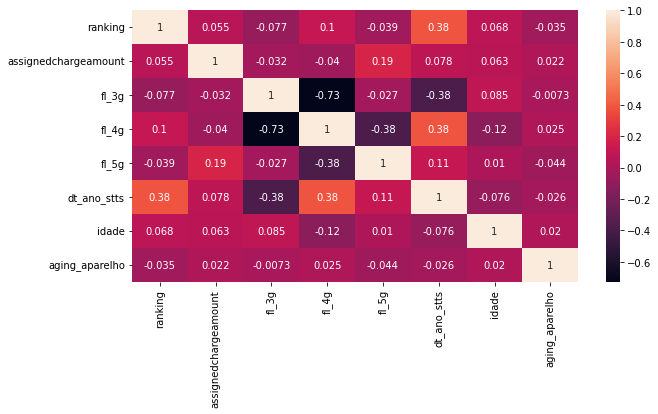

In [58]:
corr2 = corr_mes_previsao.corr()

fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(corr2, xticklabels = corr2.columns, yticklabels = corr2.columns, annot = True)

***
## Modelagem

In [59]:
# Dividindo as features em dados de treino e teste - 70% para dados de treinamento e 30% para dados de teste
X_train, X_val, y_train, y_val = train_test_split(X, 
                                                  y, 
                                                  test_size=0.5, 
                                                  random_state = 2048)

# Pré-processamento para Dados Numéricos
numerical_transformer = Pipeline([
                                  ('scaler', StandardScaler())
                                 ])

# Pré-processamento para Dados Categóricos
categorical_transformer = Pipeline([
                                    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
                                   ])

# Pré-processamento de pacote de dados numéricos e categóricos
preprocessor = ColumnTransformer(transformers=[
                                                ('num', numerical_transformer, numerical_cols),
                                                ('cat', categorical_transformer, object_cols)
                                              ], n_jobs=-1)

pipeline = Pipeline(steps=[
                            ('preprocessor', preprocessor),
                            ('smote', SMOTE(random_state=42, n_jobs=-1)),
                            ('model', GradientBoostingClassifier(random_state=2048))
                          ])

# Preprocessing of training data, fit model 
pipeline.fit(X_train, y_train)

# Predictions
# preds = np.asarray(pipeline.predict(X_val), dtype = 'int')
preds = pipeline.predict(X_val)

In [60]:
c_train = Counter(y_train)
c_train

Counter({12: 2924, 14: 2364, 18: 1884, 13: 2649, 15: 2283, 16: 2085, 17: 2136})

In [61]:
c_val = Counter(y_val)
c_val

Counter({16: 2172, 15: 2299, 18: 2024, 14: 2394, 13: 2475, 17: 2160, 12: 2801})

In [62]:
c_preds = Counter(preds)
c_preds

Counter({14: 2250, 12: 3637, 17: 1809, 15: 2806, 18: 2770, 16: 2084, 13: 969})

<AxesSubplot:>

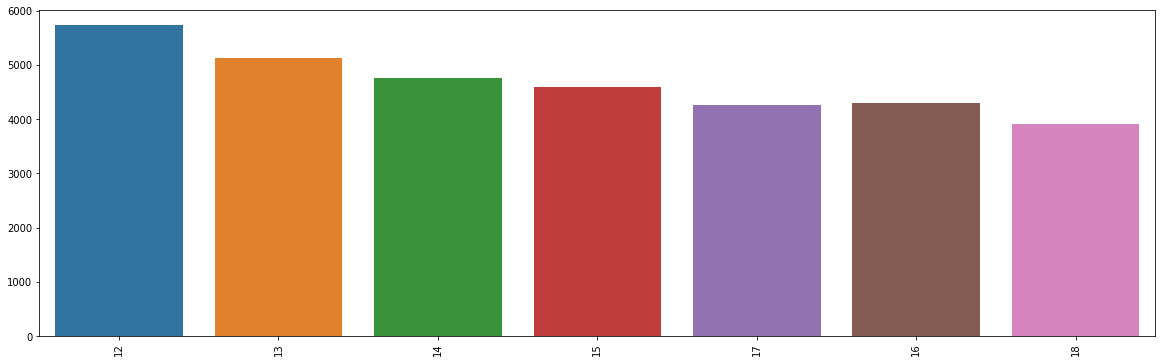

In [63]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(base_to_pred_month, 'aging_aparelho', len(base_to_pred_month['aging_aparelho'].unique()))

***
## Métricas

In [64]:
print(classification_report(y_val, preds))

              precision    recall  f1-score   support

          12       0.26      0.33      0.29      2801
          13       0.21      0.08      0.12      2475
          14       0.17      0.16      0.16      2394
          15       0.16      0.20      0.18      2299
          16       0.16      0.15      0.15      2172
          17       0.24      0.20      0.22      2160
          18       0.17      0.23      0.20      2024

    accuracy                           0.20     16325
   macro avg       0.19      0.19      0.19     16325
weighted avg       0.20      0.20      0.19     16325



In [65]:
cm_df = pd.DataFrame(confusion_matrix(y_val, preds),
                     index = sorted(Counter(y_val)),
                     columns = sorted(Counter(preds)))
cm_df

,12,13,14,15,16,17,18
12,928,216,337,435,289,186,410
13,698,200,365,409,277,168,358
14,477,150,378,499,313,184,393
15,434,126,355,456,318,227,383
16,389,121,309,348,325,300,380
17,374,86,254,341,295,432,378
18,337,70,252,318,267,312,468


## Plot non-normalized confusion matrix

Confusion matrix, without normalization
[[928 216 337 435 289 186 410]
 [698 200 365 409 277 168 358]
 [477 150 378 499 313 184 393]
 [434 126 355 456 318 227 383]
 [389 121 309 348 325 300 380]
 [374  86 254 341 295 432 378]
 [337  70 252 318 267 312 468]]
Normalized confusion matrix
[[0.33131025 0.07711532 0.12031417 0.15530168 0.10317744 0.06640486
  0.14637629]
 [0.2820202  0.08080808 0.14747475 0.16525253 0.11191919 0.06787879
  0.14464646]
 [0.19924812 0.06265664 0.15789474 0.20843776 0.13074353 0.07685881
  0.1641604 ]
 [0.18877773 0.05480644 0.15441496 0.19834711 0.13832101 0.09873858
  0.16659417]
 [0.17909761 0.05570902 0.14226519 0.16022099 0.14963168 0.13812155
  0.17495396]
 [0.17314815 0.03981481 0.11759259 0.15787037 0.13657407 0.2
  0.175     ]
 [0.16650198 0.03458498 0.12450593 0.15711462 0.131917   0.1541502
  0.2312253 ]]


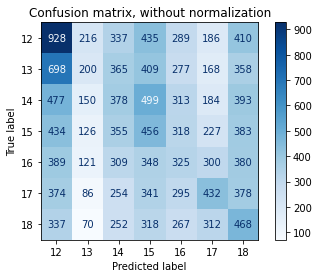

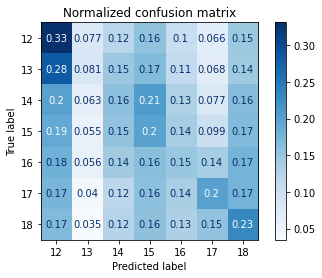

<Figure size 1296x1296 with 0 Axes>

In [66]:
titles_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        pipeline,
        X_val,
        y_val,
        display_labels=['12', '13', '14', '15', '16', '17', '18'],
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)
    
plt.figure(figsize=(18, 18))
plt.show()

***
## Mesclando resultados com tabela

### Com a base de validação

In [67]:
X_val['aging_aparelho'] = y_val
# X_val

In [68]:
X_val['previsto'] = preds
# X_val

In [69]:
X_val['cpfidentifier'] = base_to_pred_month['cpfidentifier']
# X_val

In [70]:
X_val['dt_inicio'] = base_to_pred_month['dt_inicio']
# X_val

In [71]:
X_val['dt_fim'] = base_to_pred_month['dt_fim']
# X_val

## Calculando data prevista

In [72]:
X_val['dt_fim_previsto'] = ((pd.to_datetime(X_val['dt_inicio']).dt.to_period('M')) + X_val['previsto'])
X_val

,fabricante,modelo,ranking,offertechnology,statedesc,subscribermainofferdesc,assignedchargeamount,fl_3g,fl_4g,fl_5g,dt_ano_stts,idade,aging_aparelho,previsto,cpfidentifier,dt_inicio,dt_fim,dt_fim_previsto
10355,"Motorola Mobility LLC, a Lenovo Company","SL12367845, MOTO Z PLAY (3RD GEN)",1,Controle,RIO DE JANEIRO,VIVO CONTROLE 7GB_,56.52,0.0,1.0,0.0,2017,49,16,14,7038567748,2021-06-15,NaN,2022-08
31983,APPLE,IPHONE 12 PRO MAX (A2411),1,PostPaid,MINAS GERAIS,TITULAR VIVO FAMILIA 20GB+220GB BONUS,278.69,0.0,0.0,1.0,2020,66,15,12,28778880610,2021-07-08,NaN,2022-07
12875,XIAOMI,MI 9 LITE (M1904F3BG),1,PostPaid,SAO PAULO,Titular Vivo PÃ³s FamÃ­lia 120GB,138.99,0.0,1.0,0.0,2019,47,18,14,17139946825,2020-07-13,2022-02-12,2021-09
32376,APPLE,IPHONE 11 (A2221),1,PostPaid,SAO PAULO,LINHA ADICIONAL VIVO FAMILIA 20GB+220GB BONUS,0.00,0.0,1.0,0.0,2020,48,15,17,12466761840,2021-07-02,NaN,2022-12
21869,APPLE,IPHONE XR (A2105),1,Controle,RIO DE JANEIRO,VIVO CONTROLE 7GB_,56.52,0.0,1.0,0.0,2019,21,14,12,16152588766,2021-01-05,2022-04-02,2022-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,SAMSUNG,GALAXY J3 DUOS (SM-J320M DS),1,Controle,MINAS GERAIS,VIVOCONTROLEDIGITAL-14GB ILIM_,80.47,0.0,1.0,0.0,2016,62,12,12,34398945687,2021-10-17,NaN,2022-10
24971,SAMSUNG,GALAXY J5 DUOS (SM-J500M DS),1,Controle,PARANA,VIVO CONTROLE 7GB_ANUAL_,51.27,0.0,1.0,0.0,2016,68,15,16,18687849915,2021-07-18,NaN,2022-11
12067,Samsung Korea,GALAXY S20,1,PostPaid,RIO DE JANEIRO,TITULAR VIVO POS 30GB,134.99,0.0,1.0,0.0,2019,36,18,18,11599745780,2021-03-27,NaN,2022-09
6410,Samsung Korea,GALAXY S20 FE,2,Controle,SAO PAULO,VIVO CTRL DIGITAL-11GB ILIM_,67.60,0.0,1.0,0.0,2020,47,16,17,20048163848,2021-05-22,NaN,2022-10


In [73]:
c_preds

Counter({14: 2250, 12: 3637, 17: 1809, 15: 2806, 18: 2770, 16: 2084, 13: 969})

<AxesSubplot:>

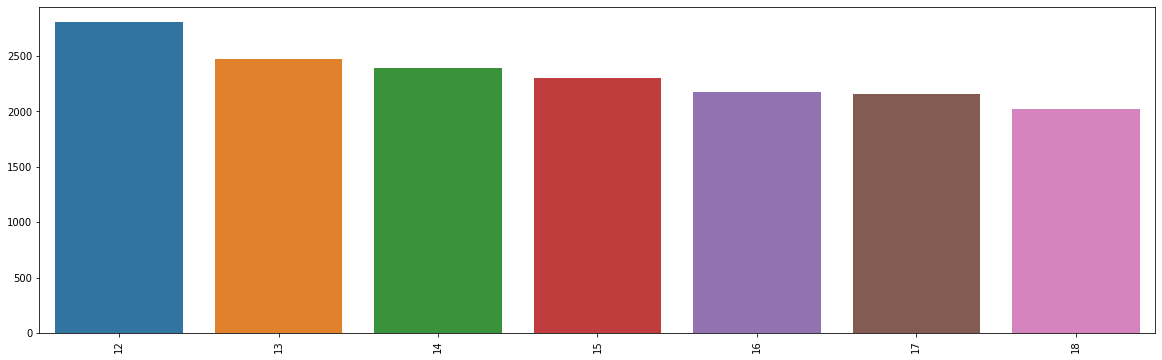

In [74]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'aging_aparelho', len(X_val['aging_aparelho'].unique()))

<AxesSubplot:>

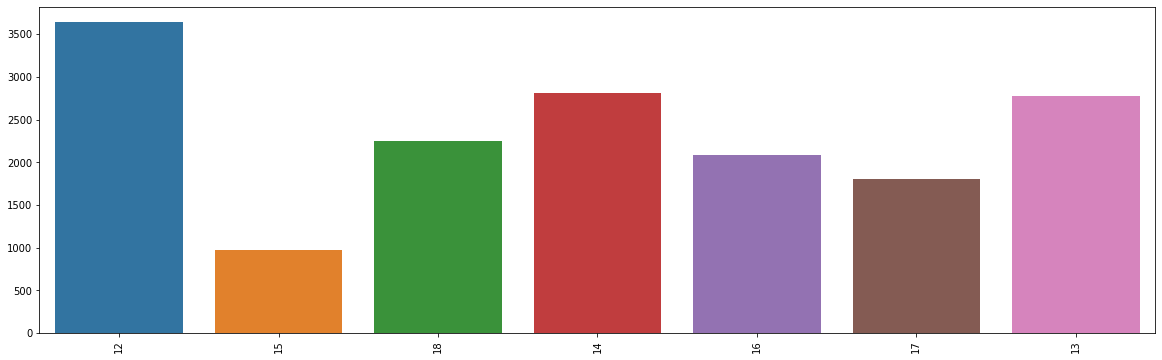

In [75]:
plt.figure(figsize=(20, 6))

# plot_feature_freq(df, feature, qt_cat)
plot_feature_freq(X_val, 'previsto', len(X_val['previsto'].unique()))